In [ ]:
# Core libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# PyTorch and Lightning
import lightning as pl
from torch.utils.data import DataLoader, Subset

# Utilities
import logging
from tqdm import tqdm

# Calvera bandit library
from calvera.bandits import LinearTSBandit
from calvera.benchmark.datasets import StatlogDataset
from calvera.benchmark import BanditBenchmarkEnvironment
from calvera.utils import ArgMaxSelector

In [2]:
# Load the Statlog dataset
dataset = StatlogDataset()

# Print dataset information
print(f"Context dimension size: {dataset.context_size}")
print(f"Total number of samples: {len(dataset)}")

Context dimension size: 63
Total number of samples: 58000


In [ ]:
# Configuration
NUM_SAMPLES = 10000
BATCH_SIZE = 32
ACCELERATOR = "cpu"

# Create data loader with a subset of the dataset
train_loader = DataLoader(
    Subset(dataset, range(NUM_SAMPLES)), 
    batch_size=BATCH_SIZE, 
    shuffle=True
)

# Initialize the bandit environment
env = BanditBenchmarkEnvironment(train_loader, device=ACCELERATOR)

# Initialize the LinearTSBandit model
bandit_module = LinearTSBandit(
    n_features=dataset.context_size,
    selector=ArgMaxSelector(),
    lazy_uncertainty_update=True,
).to(ACCELERATOR)

# Configure logging
logging.getLogger("lightning.pytorch.utilities.rank_zero").setLevel(logging.FATAL)

In [ ]:
# Initialize arrays to store metrics
rewards = np.array([])
regrets = np.array([])

# Training loop with progress bar
progress = tqdm(iter(env), total=len(env), desc="Training Linear bandit")
for contextualized_actions in progress:
    # Select actions based on current model
    chosen_actions, _ = bandit_module.forward(contextualized_actions)

    # Set up trainer for this step
    trainer = pl.Trainer(
        max_epochs=1,
        enable_progress_bar=False,
        enable_model_summary=False,
        accelerator=ACCELERATOR,
    )
    
    # Get feedback and compute regret
    chosen_contextualized_actions, realized_rewards = env.get_feedback(chosen_actions)
    batch_regret = env.compute_regret(chosen_actions)

    # Record metrics
    rewards = np.append(rewards, realized_rewards.cpu().numpy())
    regrets = np.append(regrets, batch_regret.cpu().numpy())

    # Update progress bar with current metrics
    progress.set_postfix(
        {
            "reward": realized_rewards.mean().item(),
            "regret": batch_regret.mean().item(),  # Fixed: was using reward value
            "avg_regret": regrets.mean(),
        }
    )

    # Update the bandit with feedback
    bandit_module.record_feedback(chosen_contextualized_actions, realized_rewards)
    trainer.fit(bandit_module)
    
    # Move the model back to the desired device
    # Required due to Lightning issue: https://github.com/Lightning-AI/pytorch-lightning/issues/10294
    bandit_module = bandit_module.to(ACCELERATOR)

# Create DataFrame with collected metrics
metrics = pd.DataFrame({
    "reward": rewards,
    "regret": regrets,
})

# Display the first few rows of metrics
metrics.head()

Training bandit:   0%|          | 0/313 [00:00<?, ?it/s, reward=0.125, regret=0.875, avg_regret=0.875]c:\Users\Parisa\anaconda3\envs\calvera\lib\site-packages\lightning\pytorch\core\optimizer.py:183: `LightningModule.configure_optimizers` returned `None`, this fit will run with no optimizer
c:\Users\Parisa\anaconda3\envs\calvera\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
c:\Users\Parisa\anaconda3\envs\calvera\lib\site-packages\lightning\pytorch\loops\fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
Training bandit: 100%|██████████| 313/313 [00:43<00:00,  7.15it/s, reward=0.875, regret=0.125, avg_r

,reward,regret
0,0.0,1.0
1,0.0,1.0
2,1.0,0.0
3,0.0,1.0
4,0.0,1.0


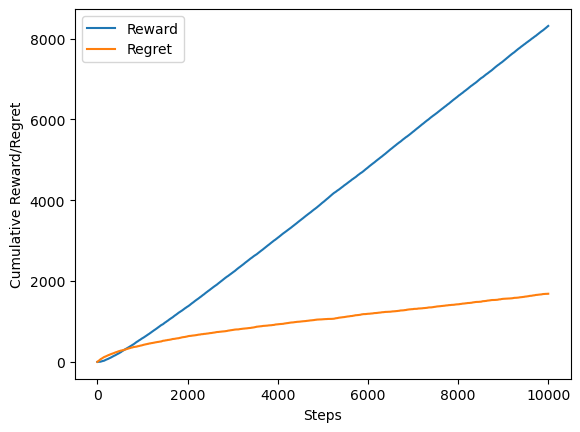

In [5]:
# Calculate cumulative metrics
cumulative_reward = np.cumsum(metrics["reward"])
cumulative_regret = np.cumsum(metrics["regret"])

# Plot cumulative regret and reward
plt.plot(cumulative_reward, label="Reward")
plt.plot(cumulative_regret, label="Regret")
plt.xlabel("Steps")
plt.ylabel("Cumulative Reward/Regret")
plt.legend()
plt.show()

In [6]:
# Calculate metrics for each time horizon
print(f"Average reward (first 10 rounds): {np.mean(metrics['reward'][:10]):.4f}")
print(f"Average reward (first 100 rounds): {np.mean(metrics['reward'][:100]):.4f}")
print(f"Average reward (all rounds): {np.mean(metrics['reward']):.4f}")
print("")
print(f"Average regret (first 10 rounds): {np.mean(metrics['regret'][:10]):.4f}")
print(f"Average regret (first 100 rounds): {np.mean(metrics['regret'][:100]):.4f}")
print(f"Average regret (all rounds): {np.mean(metrics['regret']):.4f}")

Average reward (first 10 rounds): 0.1000
Average reward (first 100 rounds): 0.1600
Average reward (all rounds): 0.8313

Average regret (first 10 rounds): 0.9000
Average regret (first 100 rounds): 0.8400
Average regret (all rounds): 0.1687
